In [1]:
import gymnasium as gym

import numpy as np
import matplotlib.pylab as plot

import pygame

from importlib import reload

import function_approximation
import nn_function_approximation

reload(function_approximation)
reload(nn_function_approximation)

from function_approximation import *
from nn_function_approximation import *

In [2]:
from math import ceil 

def windowed_avg(xs, window_size):
    avg_size = ceil(xs.shape[0] / window_size)
    avgs = np.empty(avg_size, dtype=xs.dtype)
    timesteps = np.empty(avg_size, dtype=np.int64)

    for i in range(avg_size):
        avgs[i] = xs[i * window_size: (i+1) * window_size].mean()
        timesteps[i] = i * window_size
    return timesteps, avgs


def train_multiple(environment: gym.Env, agents: dict[str, MFCAgent], n_episodes: int) -> tuple[dict[str, np.array], dict[str, np.array]]:
    reward_histories = {}
    episode_lengths = {}

    for name, agent in agents.items():
        print(f"{name}:")
        reward_history, episode_lengths_, n_terminated, n_truncated = train(environment, agent, n_episodes)

        reward_histories[name] = reward_history
        episode_lengths[name] = episode_lengths_

        print(f"#terminated: {n_terminated}, #truncated: {n_truncated}, terminated ratio {n_terminated / max(1, n_terminated + n_truncated):.2%}")
        print()

    return reward_histories, episode_lengths

In [4]:
environment = gym.make("CliffWalking-v0")
environment = gym.wrappers.TimeLimit(environment, 100)

In [5]:
n_episodes = 10_000

observation_adapter = FlattenDiscreteAdapter(environment.observation_space)

gamma=0.9
alpha_schedule=ExponentialSchedule(0.2, 4 / n_episodes)
epsilon_schedule=LinearSchedule(1.0, 0.1, n_episodes)


def make_tabular_agent(lambda_: float, n: int, bootstrap_value_fn=sarsa_bootstrap_value):
    av_estimator = TabularEstimator(observation_adapter.dim, environment.action_space.n)
    av_estimator = ActionValueEstimatorAdapterWrapper(av_estimator, observation_adapter, None)
    
    agent = MixingMultiStepAgent(
        av_estimator=av_estimator,
        n_actions=environment.action_space.n,
        gamma=gamma,
        alpha_schedule=alpha_schedule,
        epsilon_schedule=epsilon_schedule,
        lambda_=lambda_,
        n=n,
        bootstrap_value_fn=bootstrap_value_fn
    )

    return agent

In [6]:
def make_experiment_agents(bootstrap_value_fn=sarsa_bootstrap_value):
    agents = {}

    for lambda_ in [0.25, 0.5, 0.75]:
        for n in [3, 5]:
            agents[f"λ = {lambda_} n = {n}"] = make_tabular_agent(lambda_, n, bootstrap_value_fn)
    agents[f"λ = 1.0 n = 1"] = make_tabular_agent(1.0, 1, bootstrap_value_fn)

    return agents

agents = make_experiment_agents(q_learning_bootstrap_value)

In [ ]:
reward_histories, episode_lengths = train_multiple(environment=environment, agents=agents, n_episodes=n_episodes)

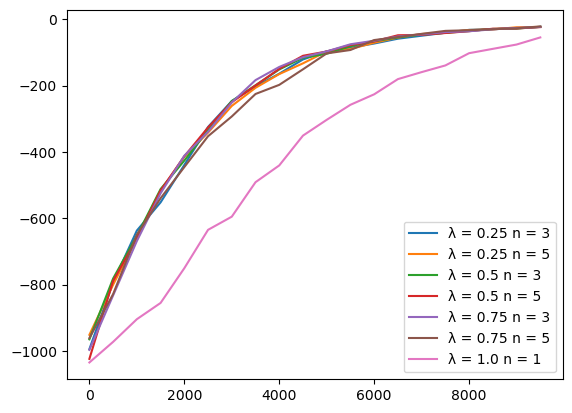

In [8]:
for name, reward_history in reward_histories.items():
    x, y = windowed_avg(reward_history, n_episodes // 20)
    plot.plot(x, y, label=name)
plot.legend()

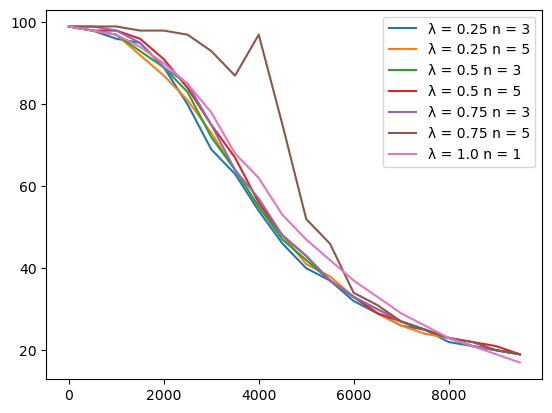

In [9]:
for name, episode_lengths_ in episode_lengths.items():
    x, y = windowed_avg(episode_lengths_, n_episodes // 20)
    plot.plot(x, y, label=name)
plot.legend()

In [3]:
environment = gym.make("CartPole-v1")

In [4]:
n_episodes = 1_000

# clamped_low = np.array([-3, -4, -0.3, -5], dtype=np.float32)
# clamped_high = -clamped_low

clamped_low = np.array([-2.4, -2, -.2095, -2], dtype=np.float32)
clamped_high = -clamped_low

clamped_space = gym.spaces.Box(clamped_low, clamped_high, (4,))

gamma=0.9
alpha_schedule=ExponentialSchedule(0.2, 4 / n_episodes)
epsilon_schedule=LinearSchedule(1.0, 0.1, n_episodes)

In [5]:
def make_linear_agent(bootstrap_value_fn=sarsa_bootstrap_value, n_divisions: int = 8, n_shifts: int = 1):
    observation_adapter = TileCodingAdapter(clamped_space, n_divisions=n_divisions, n_shifts=n_shifts)

    av_estimator = LinearActionOutEstimator(observation_adapter.size, environment.action_space.n)
    av_estimator = ActionValueEstimatorAdapterWrapper(av_estimator, observation_adapter, None)

    agent = OnlineActionValueEstimateAgent(
        av_estimator=av_estimator,
        n_actions=environment.action_space.n,
        gamma=gamma,
        alpha_schedule=alpha_schedule,
        epsilon_schedule=epsilon_schedule,
        bootstrap_value_fn=bootstrap_value_fn
    )

    return agent

In [6]:
def make_eligibility_traces_agent(lambda_: float, n_divisions: int, n_shifts: int):
    observation_adapter = TileCodingAdapter(clamped_space, n_divisions=n_divisions, n_shifts=n_shifts)

    agent = EligibilityTracesAgent(
        n_features=observation_adapter.size,
        n_actions=environment.action_space.n,
        gamma=gamma,
        lambda_=lambda_,
        alpha_schedule=alpha_schedule,
        epsilon_schedule=epsilon_schedule,
        feature_adapter=observation_adapter
    )

    return agent

In [20]:
def make_nn_agent(bootstrap_value_fn=sarsa_bootstrap_value, initial_lr: float=0.002):
    estimator = NNEstimator(environment.observation_space.shape[0], environment.action_space.n)

    alpha_schedule=ExponentialSchedule(initial_lr, 4 / n_episodes)

    agent = OnlineActionValueEstimateAgent(
        av_estimator=estimator,
        n_actions=environment.action_space.n,
        gamma=gamma,
        alpha_schedule=alpha_schedule,
        epsilon_schedule=epsilon_schedule,
        bootstrap_value_fn=bootstrap_value_fn
    )

    return agent

In [17]:
# train any nn net only for about 1000 steps, it takes ages

agents = {
    "linear_sarsa": make_linear_agent(n_divisions=8),
    "linear_q_learning": make_linear_agent(q_learning_bootstrap_value, n_divisions=8),
    "linear_expected_sarsa": make_linear_agent(expected_sarsa_bootstrap_value, n_divisions=8),
    "eligibility_traces_16div": make_eligibility_traces_agent(1.0, 16, 1),
    "eligibility_traces_8div_2shift": make_eligibility_traces_agent(1.0, 8, 2),
    "nn_sarsa": make_nn_agent(initial_lr=0.002),
    "nn_q_learning": make_nn_agent(q_learning_bootstrap_value, 0.0005),
}

# agents = {}
# for n_div in [2, 4, 8, 16]:
#     for n_shifts in [1, 2]:
#         agents[f"n_div={n_div} n_shift={n_shifts}"] = make_eligibility_traces_agent(1.0, n_divisions=n_div, n_shifts=n_shifts)

In [18]:
reward_histories, episode_lengths = train_multiple(environment=environment, agents=agents, n_episodes=n_episodes)

nn_q_learning:


100%|██████████| 1000/1000 [01:34<00:00, 10.54it/s]

#terminated: 979, #truncated: 21, terminated ratio 97.90%



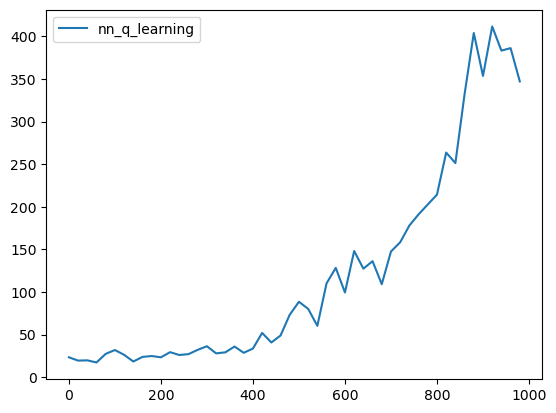

In [19]:
for name, reward_history in reward_histories.items():
    x, y = windowed_avg(reward_history, n_episodes // 50)
    plot.plot(x, y, label=name)
plot.legend()

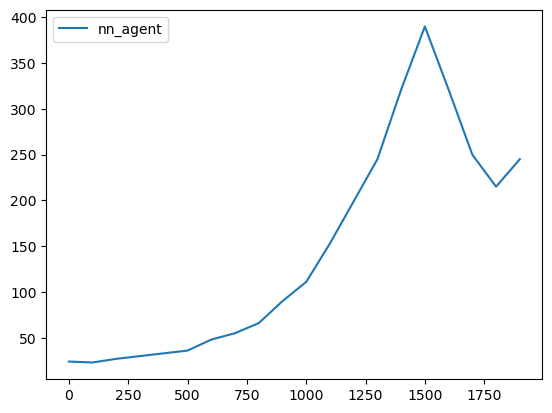

In [180]:
for name, episode_lengths_ in episode_lengths.items():
    x, y = windowed_avg(episode_lengths_, n_episodes // 20)
    plot.plot(x, y, label=name)
plot.legend()

In [22]:
import gymnasium as gym

agent = agents["nn_q_learning"]

env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()

for _ in range(500):
   action = agent.get_action(observation, eval=True)
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()
env.close()

pygame.quit()

In [134]:
import pygame
pygame.quit()

In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, n_in_features: int, n_out_features: int) -> None:
        super().__init__()

        self.dense1 = nn.Linear(n_in_features, 128)
        self.dense2 = nn.Linear(128, 128)
        self.dense3 = nn.Linear(128, n_out_features, bias=False)

        self.dense3.weight.detach().zero_()

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        return self.dense3(x)

class NNEstimator(ActionValueEstimator):
    def __init__(self, n_features: int, n_actions: int) -> None:
        super().__init__()

        self.model = Model(n_features, n_actions).cuda()

        self.optimizer = torch.optim.SGD(self.model.parameters(), 0.1, 0.95)

    def action_values(self, observation) -> np.array:
        with torch.no_grad():
            values = self.model(torch.from_numpy(observation))
            return values.numpy()

    def update(self, observation: int, action: int, target: float, alpha: float):
        for group in self.optimizer.param_groups:
            group['lr'] = alpha

        self.optimizer.zero_grad()

        x = torch.from_numpy(observation)
        values = self.model(x)
        action_value = values[action]

        loss = 0.5 * torch.square(action_value - target)
        loss.backward()

        self.optimizer.step()

In [196]:
torch.tensor([1,2]).cuda().cpu().numpy()

array([1, 2], dtype=int64)